/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


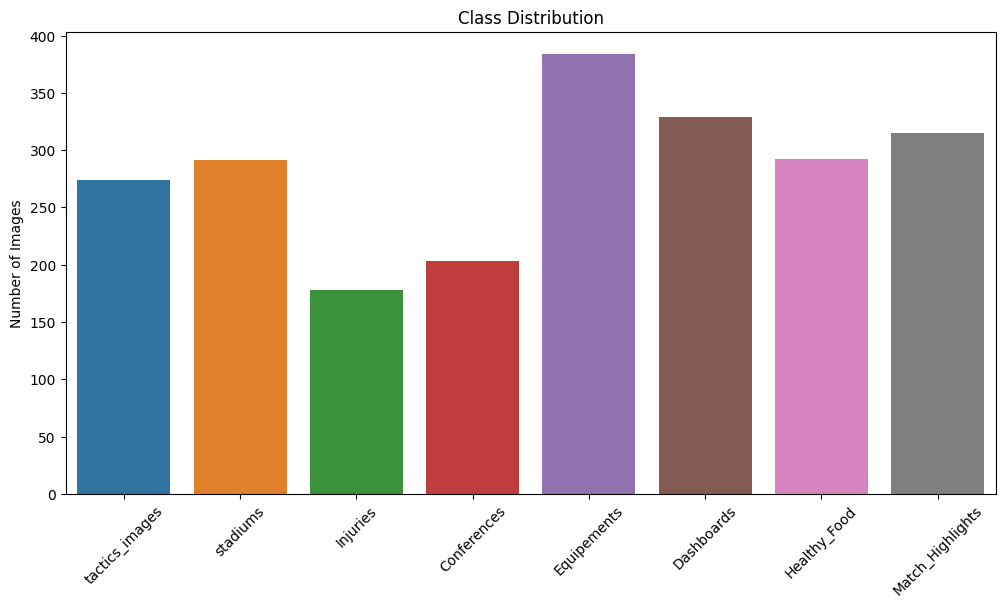

In [1]:
# 📂 Setup Paths
import os
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

DATASET_DIR = '/kaggle/input/new-dataset-football-classification/New folder'
classes = os.listdir(DATASET_DIR)
class_counts = {cls: len(os.listdir(os.path.join(DATASET_DIR, cls))) for cls in classes}

# Plot class distribution
plt.figure(figsize=(12,6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Class Distribution')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [2]:
# 🧪 Train/Test Split
import shutil

OUTPUT_DIR = 'C:/Users/bouaz/Downloads'  # 👈 Change this
for cls in classes:
    cls_path = os.path.join(DATASET_DIR, cls)
    images = os.listdir(cls_path)
    train, test = train_test_split(images, test_size=0.2, random_state=42)
    
    for phase, split in [('train', train), ('test', test)]:
        split_path = os.path.join(OUTPUT_DIR, phase, cls)
        os.makedirs(split_path, exist_ok=True)
        for img in split:
            shutil.copy(os.path.join(cls_path, img), os.path.join(split_path, img))

In [3]:
# 📸 ResNet50 Feature Extraction
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(os.path.join(OUTPUT_DIR, 'train'), transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # remove classifier
model.eval()

features, labels = [], []
with torch.no_grad():
    for imgs, lbls in tqdm(loader):
        out = model(imgs).squeeze()
        features.append(out)
        labels.extend(lbls)

features = torch.cat(features).numpy()  # shape: (N, 2048)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]
100%|██████████| 57/57 [04:04<00:00,  4.29s/it]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1810 samples in 0.004s...
[t-SNE] Computed neighbors for 1810 samples in 0.155s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1810
[t-SNE] Computed conditional probabilities for sample 1810 / 1810
[t-SNE] Mean sigma: 5.272401
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.583221
[t-SNE] KL divergence after 1000 iterations: 0.944206


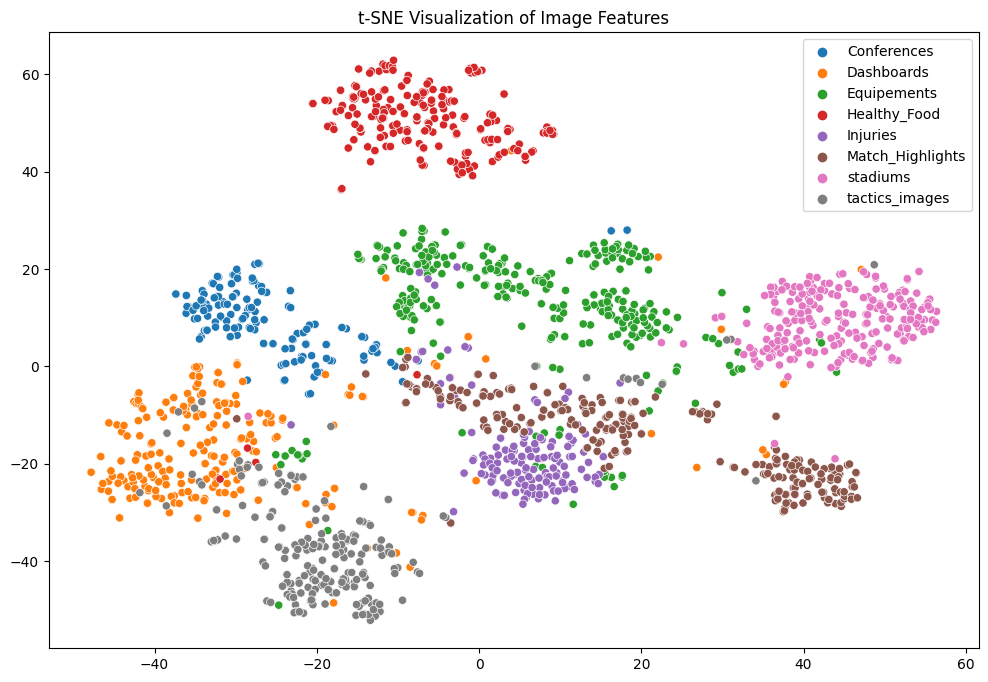

In [4]:
# 📉 PCA and t-SNE Visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA
pca = PCA(n_components=50)
pca_result = pca.fit_transform(features)

# t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30)
tsne_result = tsne.fit_transform(pca_result)

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=[dataset.classes[i] for i in labels], palette='tab10', legend='full')
plt.title('t-SNE Visualization of Image Features')
plt.show()